# B-Cubed DEMO Living Planet Symposium 2025
Maarten Trekels
## Building data cubes



### Install missing packages

In [ ]:
%pip install pygbif
%pip install dask
%pip install geopandas
%pip install netCDF4
%pip install rioxarray
%pip install cartopy
%pip install basemap
%pip install xarray-spatial
%pip install contextily
%pip install pystac_client
%pip install planetary_computer
%pip install stackstac

### Loading packages

In [1]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in cast")

from pygbif import occurrences as occ
import pandas as pd
import geopandas as gpd
from pyproj import Proj, Transformer
from shapely.geometry import mapping
from shapely.geometry import Polygon
import matplotlib.pyplot as plt


import io
from io import StringIO
import zipfile
import math
from rioxarray.rioxarray import _make_coords
from rasterio.vrt import WarpedVRT

import xrspatial.multispectral as ms

import contextily as ctx
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import rioxarray
import planetary_computer
import affine
import rasterio  # Import rasterio!
import stackstac

### Loading Earth Engine

### Example of the GBIF API through pygbif

In [ ]:
from pygbif import occurrences
data = occurrences.search(speciesKey=5229490, limit=10)

print(data['results'])

## GBIF data Cubes

### Generating the Cube

#### Exemplar JSON query for generating a data cube


```
# DON'T EXECUTE THIS CELL. FOR DEMO PUPOSE ONLY #
{
  "sendNotification": true,
  "notificationAddresses": [
    "maarten.trekels@plantentuinmeise.be"
  ],
  "format": "SQL_TSV_ZIP",
  "sql": "SELECT  PRINTF('%04d-%02d', \"year\", \"month\") AS yearMonth,
   GBIF_EEARGCode(10000, decimalLatitude,  decimalLongitude,  COALESCE(coordinateUncertaintyInMeters, 1000) ) AS eeaCellCode,
   speciesKey,
   species,
   establishmentMeans,
   degreeOfEstablishment,
   pathway,
   COUNT(*) AS occurrences,
   COUNT(DISTINCT recordedBy) AS distinctObservers
   FROM  occurrence
   WHERE occurrenceStatus = 'PRESENT'
   AND countryCode = 'BE'
   AND hasCoordinate = TRUE
   AND NOT ARRAY_CONTAINS(issue, 'ZERO_COORDINATE')
   AND NOT ARRAY_CONTAINS(issue, 'COORDINATE_OUT_OF_RANGE')
   AND NOT ARRAY_CONTAINS(issue, 'COORDINATE_INVALID')
   AND NOT ARRAY_CONTAINS(issue, 'COUNTRY_COORDINATE_MISMATCH')
   AND \"month\" IS NOT NULL
   GROUP BY yearMonth,
   eeaCellCode,
   speciesKey,
   species,
   establishmentMeans,
   degreeOfEstablishment,
   pathway
   ORDER BY  yearMonth DESC,
   eeaCellCode ASC,
   speciesKey ASC"
}


```



## Loading the Data Cube in Python

### Matching the GBIF download with a geometry

ONLY EXECUTE THIS SECTION IF YOU DON'T WANT TO USE THE PRE GENERATED GEOPARQUET FILES

You can download a pre generated data cube from GitHub or any other online resource.

#### Get data from Drive

In [ ]:
def convert_to_int(x):
       try:
           return int(x)
       except ValueError:
           return pd.NA  # or np.nan if you prefer NumPy NaNs

data = pd.read_csv('./data/YOUR_GBIF_DOWNLOAS.csv', sep='\t', converters={'familykey': convert_to_int, 'specieskey': convert_to_int})

data['familykey'] = pd.to_numeric(data['familykey'], errors='coerce').astype('Int64')
data['specieskey'] = pd.to_numeric(data['specieskey'], errors='coerce').astype('Int64')


In [ ]:
print(data)

#### Getting a Geopackage file from the Grid that you use

In [ ]:
input_file = "./data/YOUR_GRID.gpkg"

qdgc_ref = gpd.read_file(input_file, layer='tbl_qdgc_03')

In [ ]:
print(qdgc_ref)

#### Merging the Data cube with the grid

In [ ]:
test_merge = pd.merge(data, qdgc_ref, left_on='qdgccode', right_on='qdgc')

In [ ]:
# Convert to GeoDataFrame

gdf = gpd.GeoDataFrame(test_merge, geometry='geometry')

gdf = gdf.set_crs(epsg=4326, inplace=False)

## Loading the data from a GeoParquet file

### Loading the data as GeoDataFrames

In [2]:
gbif_cube = './data/data_ZA.parquet'
gbif_points = './data/data_ZA_occurrence.parquet'

gdf_cube = gpd.read_parquet(gbif_cube)
gdf_point = gpd.read_parquet(gbif_points)

In [3]:
print(gdf_cube)

       kingdom  kingdomkey        phylum  phylumkey          class  classkey  \
0      Plantae           6  Tracheophyta    7707728  Magnoliopsida       220   
1      Plantae           6  Tracheophyta    7707728  Magnoliopsida       220   
2      Plantae           6  Tracheophyta    7707728  Magnoliopsida       220   
3      Plantae           6  Tracheophyta    7707728  Magnoliopsida       220   
4      Plantae           6  Tracheophyta    7707728  Magnoliopsida       220   
...        ...         ...           ...        ...            ...       ...   
11040  Plantae           6  Tracheophyta    7707728  Magnoliopsida       220   
11041  Plantae           6  Tracheophyta    7707728  Magnoliopsida       220   
11042  Plantae           6  Tracheophyta    7707728  Magnoliopsida       220   
11043  Plantae           6  Tracheophyta    7707728  Magnoliopsida       220   
11044  Plantae           6  Tracheophyta    7707728  Magnoliopsida       220   

         order  orderkey    family  fam

### Filtering data (e.g. on species)
Check for a single species (Acacia mearnsii De Wild.: https://www.gbif.org/species/2979775)

In [4]:
gdf_cube = gdf_cube[gdf_cube['specieskey'].eq(2979775)]
gdf_point = gdf_point[gdf_point['speciesKey'].eq(2979775.0)]

## Visualization of the data cubes on a map with different layers

### Plotting the data on OpenStreetMap

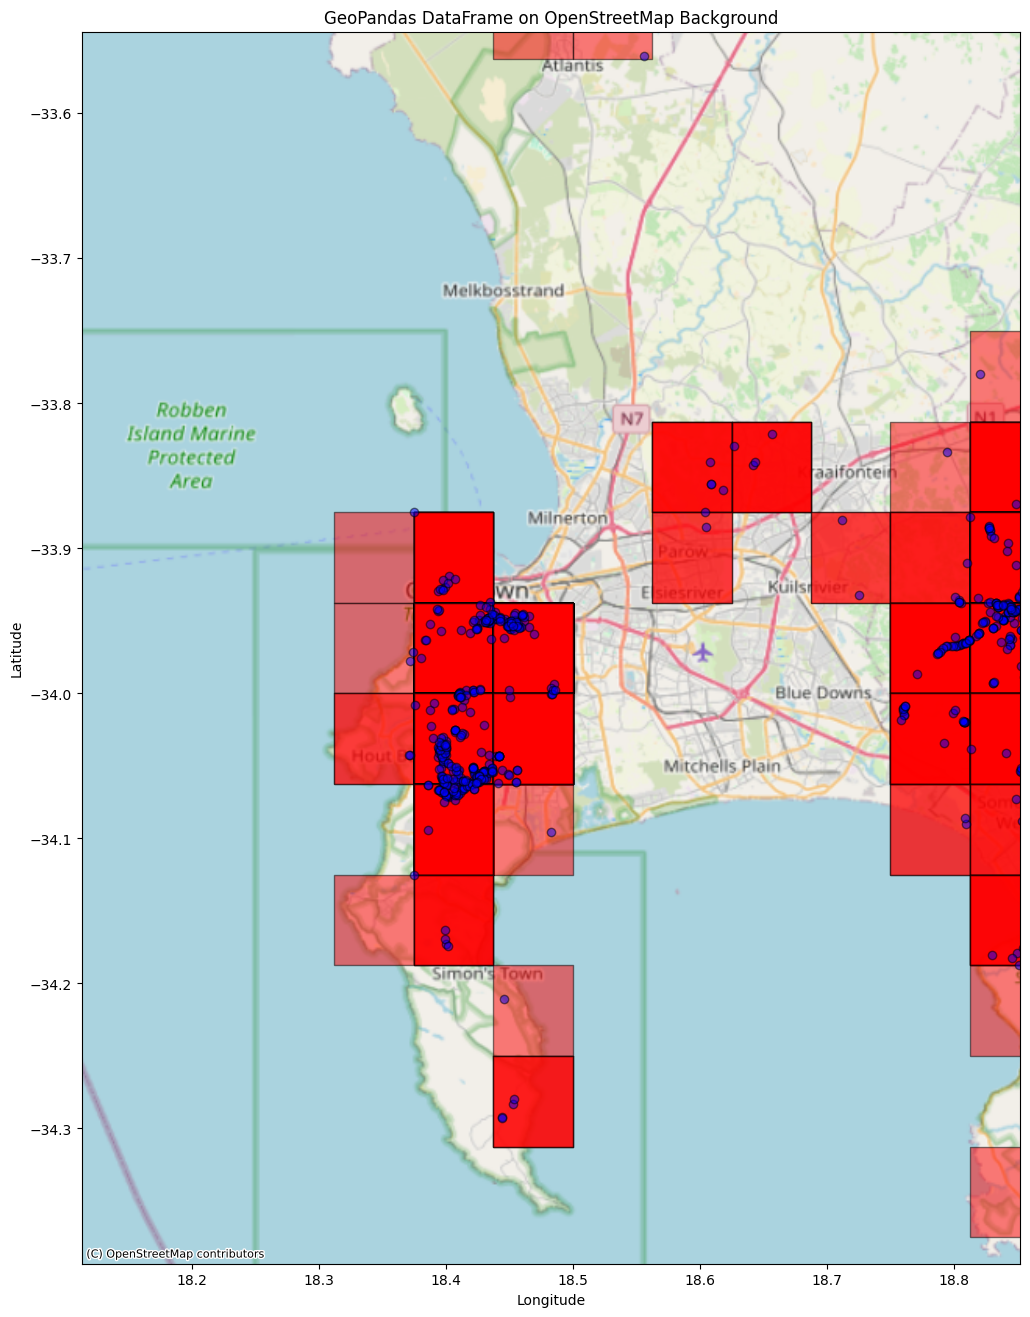

In [5]:


bbox_total = gdf_cube.total_bounds

bbox = [18.113532, -34.393312, 18.852118, -33.543684] #ZA bbox

aoi = {
    "type": "Polygon",
    "coordinates": [[
        [bbox[0], bbox[1]],
        [bbox[2], bbox[1]],
        [bbox[2], bbox[3]],
        [bbox[0], bbox[3]],
        [bbox[0], bbox[1]],
    ]],
}




# 5. Plot the Data
fig, ax = plt.subplots(figsize=(20, 16))


# Plot the GeoDataFrames
gdf_cube.plot(ax=ax, color="red", edgecolor="black", linewidth=1, alpha=0.5)
gdf_point.plot(ax=ax, color="blue", edgecolor="black", linewidth=1, alpha=0.5)

# Adjust Axes
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs="EPSG:4326")


# Labels and Title
plt.title("GeoPandas DataFrame on OpenStreetMap Background")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the Plot
plt.show()

### Getting Sentinel-2 image from Microsoft Planetary Computer

In [6]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)


items = catalog.search(
    collections=["sentinel-2-l2a"],
    query={"id": {"eq": "S2B_MSIL2A_20250404T081609_R121_T34HBH_20250404T120818"}}
).items()


least_cloudy_item = next(items)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

scene_data = (
    stackstac.stack(
        [least_cloudy_item.to_dict()],
        epsg=4326,
        resampling=rasterio.enums.Resampling.bilinear,
        #resolution=0.001,  # resolution in the output CRS’s units
        assets=["B04", "B03", "B02"],  # red, green, blue bands
        chunksize=2048,
    )
    .isel(time=0)
    .persist()
)

scene_data

Choosing S2B_MSIL2A_20250404T081609_R121_T34HBH_20250404T120818 from 2025-04-04 with 2.005319% cloud cover


<xarray.DataArray 'stackstac-2a49b23b9ff19b22b940b9e0eff1c21a' (band: 3,
                                                                y: 10981,
                                                                x: 10981)> Size: 3GB
dask.array<getitem, shape=(3, 10981, 10981), dtype=float64, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates: (12/45)
    time                                     datetime64[ns] 8B 2025-04-04T08:...
    id                                       <U54 216B 'S2B_MSIL2A_20250404T0...
  * band                                     (band) <U3 36B 'B04' 'B03' 'B02'
  * x                                        (x) float64 88kB 17.74 ... 18.95
  * y                                        (y) float64 88kB -33.4 ... -34.41
    s2:high_proba_clouds_percentage          float64 8B 0.5189
    ...                                       ...
    proj:shape                               object 8B {10980}
    gsd                                      float64 8B 10.0
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(17.736915050109257, -34.411...
    crs:            epsg:4326
    transform:      | 0.00, 0.00, 17.74|\n| 0.00,-0.00,-33.40|\n| 0.00, 0.00,...
    resolution_xy:  (0.00011084602003642967, 9.237950819672146e-05)

### Overlaying Cube With Sentinel data

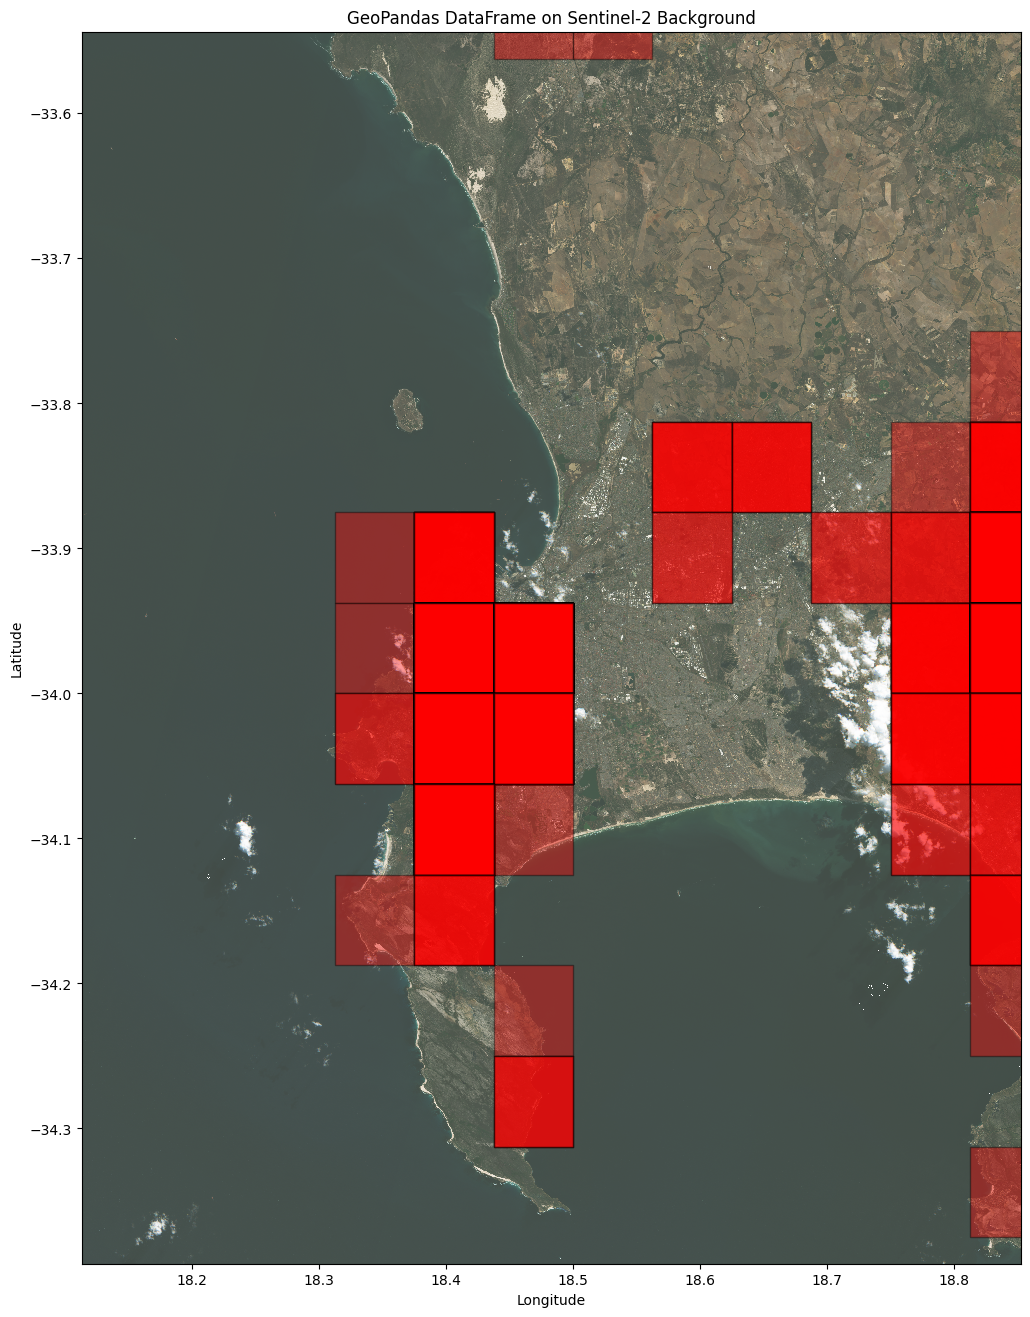

In [7]:
import matplotlib.pyplot as plt
import xrspatial.multispectral as ms

#... (your code to generate scene_data and filtered_gdf)

# 5. Plot the Data
fig, ax = plt.subplots(figsize=(20, 16))

# Create the true-color image
sentinel_img = ms.true_color(*scene_data)  # No need for name="epsg=4326" here

# Plot the Sentinel-2 image on the existing axes
sentinel_img.plot.imshow(ax=ax, add_colorbar=False)  # Plot on 'ax', remove extra colorbar

# Plot the GeoDataFrame on the same axes
gdf_cube.plot(ax=ax, color="red", edgecolor="black", linewidth=1, alpha=0.4)

# Adjust Axes
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

# Labels and Title
plt.title("GeoPandas DataFrame on Sentinel-2 Background")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the Plot
plt.show()

## EBV data cubes in NetCDF format

In [9]:
import netCDF4 as nc
import xarray as xr


birds_file = xr.open_dataset('./data/viti_spepop_id77_20240206_v1.nc')

print(birds_file)

<xarray.Dataset> Size: 26kB
Dimensions:  (lon: 559, lat: 437, time: 1, entity: 486)
Coordinates:
  * lon      (lon) float64 4kB 9.45e+05 9.55e+05 ... 6.515e+06 6.525e+06
  * lat      (lat) float64 3kB 5.305e+06 5.295e+06 ... 9.55e+05 9.45e+05
  * time     (time) datetime64[ns] 8B 2018-01-01
  * entity   (entity) |S37 18kB b'Gavia stellata                       ' ... ...
Data variables:
    crs      |S1 1B ...
Attributes: (12/38)
    Conventions:                CF-1.8, ACDD-1.3, EBV-1.0
    naming_authority:           The German Centre for Integrative Biodiversit...
    history:                    EBV netCDF created using ebvcube, 2024-02-06
    ebv_vocabulary:             https://portal.geobon.org/api/v1/ebv
    ebv_cube_dimensions:        lon, lat, time, entity
    keywords:                   ebv_class: Species populations, ebv_name: Spe...
    ...                         ...
    geospatial_lat_units:       meter
    time_coverage_start:        2013-01-01
    time_coverage_end:       

In [10]:
def print_netcdf_structure(nc_file_path):
  """Prints the structure (groups, variables, and their paths) of a NetCDF file.

  Args:
    nc_file_path: Path to the NetCDF file.
  """
  def print_group_structure(group, path=""):
    """Recursively prints the structure of a group within the NetCDF file."""
    for var_name in group.variables:
      print(f"{path}/{var_name}")  # Print variable path
    for group_name in group.groups:
      subgroup = group.groups[group_name]
      print_group_structure(subgroup, f"{path}/{group_name}")  # Recursively explore subgroups

  with nc.Dataset(nc_file_path, 'r') as nc_file:
    print_group_structure(nc_file)  # Start with the root group

# Example usage:
nc_file_path = './data/viti_spepop_id77_20240206_v1.nc'
print_netcdf_structure(nc_file_path)

/lon
/lat
/time
/crs
/entity
/metric_1/ebv_cube


In [11]:
print(birds_file.variables)

Frozen({'lon': <xarray.IndexVariable 'lon' (lon: 559)> Size: 4kB
array([ 945000.,  955000.,  965000., ..., 6505000., 6515000., 6525000.])
Attributes:
    long_name:      lon
    standard_name:  projection_x_coordinate
    axis:           X
    units:          meter, 'lat': <xarray.IndexVariable 'lat' (lat: 437)> Size: 3kB
array([5305000., 5295000., 5285000., ...,  965000.,  955000.,  945000.])
Attributes:
    long_name:      lat
    standard_name:  projection_y_coordinate
    axis:           Y
    units:          meter, 'time': <xarray.IndexVariable 'time' (time: 1)> Size: 8B
array(['2018-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    long_name:  time
    axis:       T, 'crs': <xarray.Variable ()> Size: 1B
[1 values with dtype=|S1]
Attributes:
    spatial_ref:                     PROJCRS["ETRS89-extended / LAEA Europe",...
    GeoTransform:                    940000 10000 0.0 5310000 0.0 -10000
    grid_mapping_name:               lambert_azimuthal_equal_area
    l

In [12]:
time = birds_file.variables['time']
print(time)

print(birds_file['entity'])

<xarray.IndexVariable 'time' (time: 1)> Size: 8B
array(['2018-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    long_name:  time
    axis:       T
<xarray.DataArray 'entity' (entity: 486)> Size: 18kB
array([b'Gavia stellata                       ',
       b'Gavia arctica                        ',
       b'Tachybaptus ruficollis               ', ...,
       b'Accipiter gentilis all others        ',
       b'Melanitta nigra s. str.              ',
       b'Sylvia subalpina                     '], dtype='|S37')
Coordinates:
  * entity   (entity) |S37 18kB b'Gavia stellata                       ' ... ...
Attributes:
    units:                           1
    ebv_entity_type:                 Species
    ebv_entity_scope:                Bird species listed under the Art. 12 of...
    ebv_entity_classification_name:  Species names as accepted by the Birds D...
    ebv_entity_classification_url:   https://cdr.eionet.europa.eu/help/birds_...
    long_name:                     

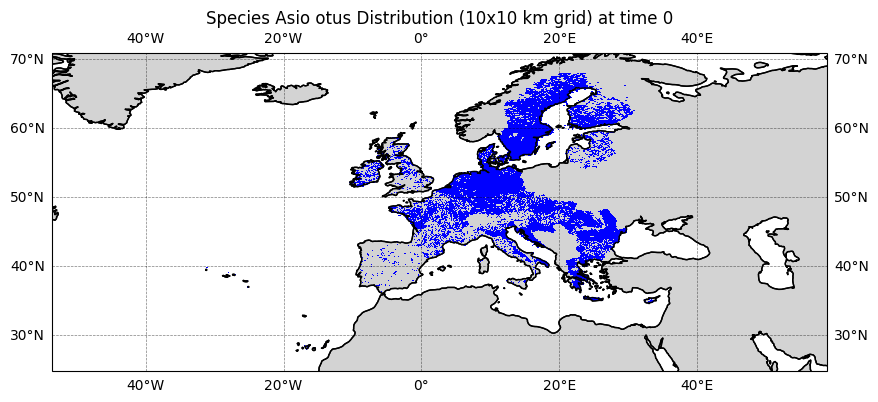

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
from pyproj import Transformer
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- Load Dataset Efficiently ---
birds_file = xr.open_dataset(
    './data/viti_spepop_id77_20240206_v1.nc',
    group="metric_1",
    chunks={'entity': 1, 'time': 1}  # Load only one entity/time slice at a time
)

# --- Select Target Species and Time ---
species_index = 150  # Change to the species index you need
time_index = 0  # Change to the desired time index

# Extract only the required slice
species_data_subset = birds_file['ebv_cube'].sel(entity=species_index, time=time_index).compute()

# Convert to a 2D array
species_distribution_2d = np.squeeze(species_data_subset)

# --- Load Longitude and Latitude (Only Once) ---
with xr.open_dataset('./data/viti_spepop_id77_20240206_v1.nc') as ds:
    lon = ds['lon'].values  # 1D array (size: 559)
    lat = ds['lat'].values  # 1D array (size: 437)

# --- Create Meshgrid Efficiently ---
lon_grid, lat_grid = np.meshgrid(lon, lat)

# --- Efficient Coordinate Transformation ---
transformer = Transformer.from_crs("epsg:3035", "epsg:4326", always_xy=True)

# Transform the entire 2D meshgrid
lon_deg, lat_deg = transformer.transform(lon_grid, lat_grid)

# --- Create the Plot ---
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features
ax.coastlines()
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

# --- 🔹 Fix: Use Discrete Colormap Without Color Bar ---
unique_values = np.unique(species_distribution_2d)

# If only one value, choose a single solid color
if len(unique_values) == 1:
    cmap = ListedColormap(["red"])  # Single-color for uniform data
    norm = None
else:
    cmap = ListedColormap(["white", "blue"])  # Adjust colors as needed
    norm = BoundaryNorm([0, 0.5, 1], cmap.N)

# --- 🔹 Fix: Use `shading="nearest"` to Ensure Correct Grid Alignment ---
cs = ax.pcolormesh(
    lon_deg, lat_deg, species_distribution_2d,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    shading='nearest'  # Prevents visual distortion
)

# --- 🔹 Completely Remove Color Bar ---
# No `fig.colorbar(cs)`, so no scale bar will be shown

# --- Get the Species Name Efficiently ---
with xr.open_dataset('./data/viti_spepop_id77_20240206_v1.nc') as ds:
    species_name = ds['entity'].values[species_index].decode('utf-8').strip()

# --- Final Plot Customization ---
ax.set_title(f"Species {species_name} Distribution (10x10 km grid) at time {birds_file['time'].values[time_index].item()}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# --- 🔹 Fix: Add Grid Lines to Show Exact 10x10 km Cells ---
gridlines = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="black", alpha=0.5)

# Show the plot
plt.show()
